In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


# Data cleaning

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/chunthebear/reinforcement-learning-medication-recommendation-system-for-diabetic-patients/main/data/diabetic_data.csv", index_col='encounter_id', na_values="?", low_memory=False)
raw_data.shape

(101766, 49)

In [3]:
# Get an idea of how many features are missing values, and how many values they're missing:

def percent_null(data):
    # Returns a Pandas series of what percentage of each feature of 'data' contains NaN values
    pc_null = data.apply(pd.Series.isnull).apply(lambda x: 100*round(len(x[x==True])/len(x), 4))
    return pc_null[pc_null!=0]
percent_null(raw_data)

race                  2.23
weight               96.86
payer_code           39.56
medical_specialty    49.08
diag_1                0.02
diag_2                0.35
diag_3                1.40
dtype: float64

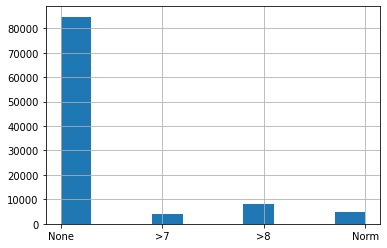

In [ ]:
raw_data['A1Cresult'].hist()#.value_counts()

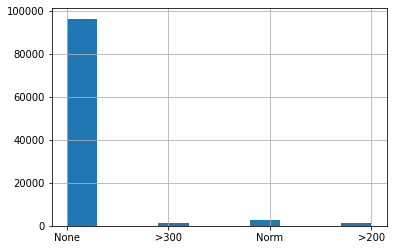

In [ ]:
raw_data['max_glu_serum'].hist()

In [ ]:
raw_data[['max_glu_serum','A1Cresult']].value_counts()

max_glu_serum  A1Cresult
None           None         79700
               >8            8039
               Norm          4932
               >7            3749
Norm           None          2499
>200           None          1414
>300           None          1135
               >8             112
Norm           Norm            39
>200           >8              36
Norm           >7              30
               >8              29
>200           >7              18
               Norm            17
>300           >7              15
               Norm             2
dtype: int64

In [ ]:

# feature_value_counts = [] # A list to put Series containing the number of entries for each level of a feature
# for feature in raw_data.columns:
#     feature_value_counts.append(raw_data[feature].value_counts())
# for i in feature_value_counts:
#     print(i)
#     print()


In [4]:
data = raw_data.copy()

## Remove duplicates if any

In [5]:
data = data.drop_duplicates()

In [ ]:
data.shape

(101766, 49)

## Keep only one encounter per patient (ensuring independence)

In [6]:
from sklearn.metrics.pairwise import pairwise_distances

def one_entry(data):
    unique_entry = data.iloc[0,:]
    return unique_entry

data = data.groupby('patient_nbr').apply(one_entry)

In [ ]:
data.shape

(71518, 49)

In [ ]:
len(data['patient_nbr'].drop_duplicates())

71518

In [ ]:
data

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,135,Caucasian,Female,[50-60),NaN,2,1,1,8,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
378,378,Caucasian,Female,[50-60),NaN,3,1,1,2,NaN,...,No,No,No,No,No,No,No,No,No,NO
729,729,Caucasian,Female,[80-90),NaN,1,3,7,4,MC,...,No,No,No,No,No,No,No,No,Yes,NO
774,774,Caucasian,Female,[80-90),NaN,1,1,7,3,NaN,...,No,No,No,No,No,No,No,Ch,Yes,NO
927,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,189351095,Caucasian,Female,[80-90),NaN,1,1,7,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
189365864,189365864,Other,Male,[60-70),NaN,1,1,7,3,HM,...,No,Steady,No,No,No,No,No,No,Yes,NO
189445127,189445127,Caucasian,Female,[80-90),NaN,1,1,7,3,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,NO


## Remove unusable / unimportant features

In [16]:
processed_data = data.copy()

In [17]:
# remove unusable features 
processed_data.reset_index(drop=True, inplace = True)

processed_data.drop(['weight', 'patient_nbr', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

In [9]:
processed_data.shape

(71518, 45)

## Impute for missing values

In [18]:
# Impute for missing values by response class
for response in processed_data['readmitted'].unique():
    response_df = processed_data[processed_data.readmitted == response].copy()
    
    # Impute for medical specialties
    # response_df = response_df.sort_values(['diag_1', 'age', 'admission_source_id']) # Clusters similar medical specialties
    # response_df['medical_specialty'] = response_df['medical_specialty'].fillna(method='bfill') # backward-fill null values
    
    # Impute for race
    response_df['race'] = response_df['race'].fillna(value=response_df['race'].describe().top) # Mode vaue for race
    
    # Impute for diagnoses
    response_df['diag_1'] = response_df['diag_1'].fillna(value=response_df['diag_1'].describe().top)
    response_df['diag_2'] = response_df['diag_2'].fillna(value=response_df['diag_2'].describe().top) # Mode values
    response_df['diag_3'] = response_df['diag_3'].fillna(value=response_df['diag_3'].describe().top)
    
    # Insert imputed data back into main DataFrame
    processed_data[processed_data.readmitted == response] = response_df


In [11]:
percent_null(processed_data)

Series([], dtype: float64)

In [ ]:
processed_data.shape

(71518, 45)

## Reducing number of variables for a feature

In [19]:
# Diagnosis
def ICD9_classifier(diagnoses):
    # Returns a series of strings corresponding to type of ICD9 diagnosis
    # diagnoses is a list
    gr_diagnoses = diagnoses.copy()
    icd9_dct = {
                'Infectious':(1, 139),
                'Neoplasmic':(140,239),
                'Hormonal':(240, 279),
                'Blood':(280,289),
                'Mental':(290,319),
                'Nervous':(320,359),
                'Sensory':(360,389),
                'Circulatory':(390,459),
                'Respiratory':(460,519),
                'Digestive':(520,579),
                'Genitourinary':(580,629),
                'Childbirth':(630,679),
                'Dermatological':(680,709),
                'Musculoskeletal':(710,739),
                'Congenital':(740,759),
                'Perinatal':(760,779),
                'Miscellaneous':(780,799),
                'Injury':(800,999)
               }
    for i, diagnosis in enumerate(diagnoses):
        if (str(diagnoses[i])[0] == 'E') or (str(diagnoses[i])[0] == 'V'):
            gr_diagnoses[i] = 'Accidental'
        elif (str(diagnoses[i]).lower() == 'nan'):
            gr_diagnoses[i] = 'NaN'
        else:
            for key, icd_range in icd9_dct.items():
                if (int(float(diagnoses[i])) >= icd_range[0]) and (int(float(diagnoses[i])) <= icd_range[1]):
                    gr_diagnoses[i] = key
    return gr_diagnoses

d1 = ICD9_classifier(processed_data['diag_1'].values)
d2 = ICD9_classifier(processed_data['diag_2'].values)
d3 = ICD9_classifier(processed_data['diag_3'].values)

processed_data['diag_1'] = d1
processed_data['diag_2'] = d2
processed_data['diag_3'] = d3

In [20]:
# readmitted

col_readmitted = []
for val in processed_data['readmitted']:
    if val == "NO":
        col_readmitted.append(0)
    elif val == ">30" or val == "<30":
        col_readmitted.append(1)

processed_data['readmitted'] = col_readmitted
print(processed_data['readmitted'].value_counts())

0    42985
1    28533
Name: readmitted, dtype: int64


## Feature engineering

In [ ]:
processed_data.shape

(71518, 45)

In [21]:
from tqdm import tqdm



health_index_total = processed_data['number_emergency'].sum() + processed_data['number_inpatient'].sum() + \
                              processed_data['number_outpatient'].sum() 

processed_data['health_index'] = 1 - ( processed_data['number_emergency'] + processed_data['number_inpatient'] + \
                              processed_data['number_outpatient'] ) / health_index_total

severity_of_disease_total = processed_data['time_in_hospital'].sum() + processed_data['num_procedures'].sum() + \
                              processed_data['num_medications'].sum() + processed_data['num_lab_procedures'].sum() + \
                              processed_data['number_diagnoses'].sum()

processed_data['severity_of_disease'] = (processed_data['time_in_hospital'] + processed_data['num_procedures'] + \
                              processed_data['num_medications'] + processed_data['num_lab_procedures'] + \
                              processed_data['number_diagnoses']) / severity_of_disease_total

drugList = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


In [ ]:
processed_data.shape

(71518, 47)

In [23]:
processed_data['discharge_disposition_id'] = processed_data['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

# processed_data = processed_data[~processed_data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [24]:
processed_data['admission_type_id'] = processed_data['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

In [25]:
processed_data['admission_source_id'] = processed_data['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [26]:
processed_data['max_glu_serum'] = processed_data['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

In [27]:
processed_data['A1Cresult'] = processed_data['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

In [28]:
processed_data = processed_data.drop(processed_data.loc[processed_data['gender'] == 'Unknown/Invalid'].index)

## Separate datasets into 3 sets for clustering data (states), drug data (actions), and output data (feedback)

In [29]:
engineered_data = processed_data.copy()

In [ ]:
engineered_data.shape

(71515, 47)

In [30]:
state_data = engineered_data.drop(['metformin', 'repaglinide', 'nateglinide'
, 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide'
, 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol'
, 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin'
, 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone'
, 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'
, 'time_in_hospital', 'num_lab_procedures'
, 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency'
, 'number_inpatient', 'number_diagnoses'
], axis = 1)

action_data = engineered_data.drop(['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id'
, 'admission_source_id', 'time_in_hospital', 'num_lab_procedures'
, 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency'
, 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses'
, 'max_glu_serum', 'A1Cresult', 'readmitted', 'health_index', 'severity_of_disease'#, 'number_of_changes'
], axis = 1)

feedback_data = engineered_data['readmitted']

In [31]:
print(state_data.shape)

(71515, 13)


## Process state data

### convert string values into integer labels

In [32]:
# convert string values into integer labels
from sklearn.preprocessing import LabelEncoder

# for col_name in state_features:
state_features = ['age', 'race', 'gender', 'admission_type_id', 'discharge_disposition_id'
, 'admission_source_id', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']

for col_name in state_features:
    le = LabelEncoder()
    le.fit(state_data[col_name])
    state_data[col_name] = le.transform(state_data[col_name])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(col_name)
    print(le_name_mapping)
    print()

age
{'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}

race
{'AfricanAmerican': 0, 'Asian': 1, 'Caucasian': 2, 'Hispanic': 3, 'Other': 4}

gender
{'Female': 0, 'Male': 1}

admission_type_id
{1: 0, 3: 1, 4: 2, 5: 3}

discharge_disposition_id
{1: 0, 2: 1, 7: 2, 10: 3, 11: 4, 18: 5, 27: 6, 28: 7}

admission_source_id
{1: 0, 4: 1, 7: 2, 8: 3, 9: 4, 11: 5}

diag_1
{'Accidental': 0, 'Blood': 1, 'Childbirth': 2, 'Circulatory': 3, 'Congenital': 4, 'Dermatological': 5, 'Digestive': 6, 'Genitourinary': 7, 'Hormonal': 8, 'Infectious': 9, 'Injury': 10, 'Mental': 11, 'Miscellaneous': 12, 'Musculoskeletal': 13, 'Neoplasmic': 14, 'Nervous': 15, 'Respiratory': 16, 'Sensory': 17}

diag_2
{'Accidental': 0, 'Blood': 1, 'Childbirth': 2, 'Circulatory': 3, 'Congenital': 4, 'Dermatological': 5, 'Digestive': 6, 'Genitourinary': 7, 'Hormonal': 8, 'Infectious': 9, 'Injury': 10, 'Mental': 11, 'Miscellaneous': 12, 'Musculos

In [ ]:
print(state_data.iloc[0])
print()

race                         2.000000
gender                       0.000000
age                          5.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
diag_1                       3.000000
diag_2                      10.000000
diag_3                       6.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
health_index                 1.000000
severity_of_disease          0.000026
Name: 0, dtype: float64



### Remove outliers (for numeric variables)

In [33]:
from collections import Counter
from scipy import stats

outlier_removal = (np.abs(stats.zscore(state_data[['age', 'health_index', 'severity_of_disease']])) < 3).all(axis=1) # , 'number_of_changes'
# outlier_removal = (np.abs(stats.zscore(state_data[['age', 'time_in_hospital', 'num_lab_procedures',
#  'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
#  'number_inpatient', 'number_diagnoses']])) < 3).all(axis=1) 
print(Counter(outlier_removal))

Counter({True: 69011, False: 2504})


In [34]:
state_data = state_data[outlier_removal].reset_index(drop=True)
action_data = action_data[outlier_removal].reset_index(drop=True)
feedback_data = feedback_data[outlier_removal].reset_index(drop=True)

In [ ]:
print(state_data.shape, action_data.shape, feedback_data.shape)

(69011, 13) (69011, 25) (69011,)


### One hot encode nominal features

In [26]:
state_data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'health_index',
       'severity_of_disease'],
      dtype='object')

In [35]:
state_data = pd.get_dummies(state_data, columns=['race', 'gender','admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult'])

### Normalization for state data 


In [37]:
state_data_num = state_data[state_data.columns]
state_data_num = (state_data_num-state_data_num.min()) / (state_data_num.max()-state_data_num.min())
state_data[state_data.columns] = state_data_num

### Histogram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


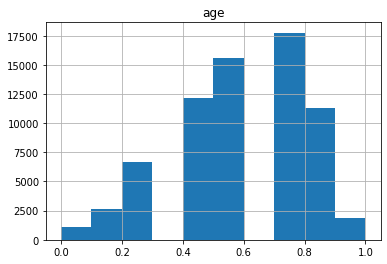

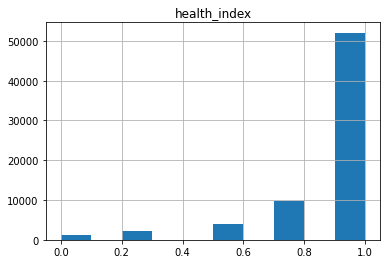

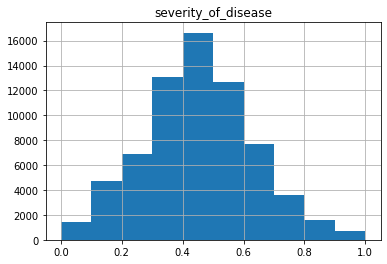

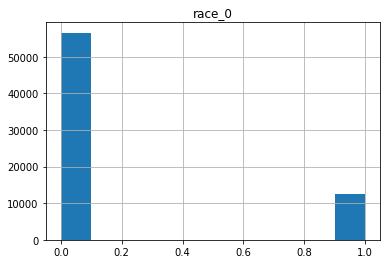

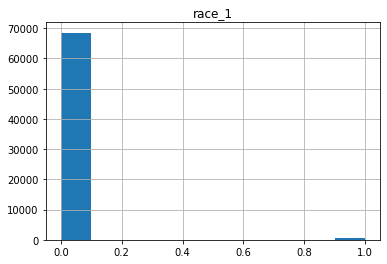

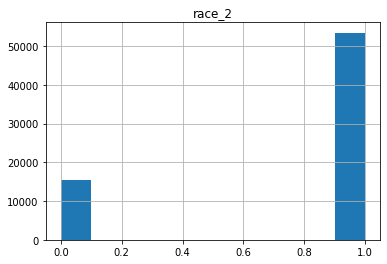

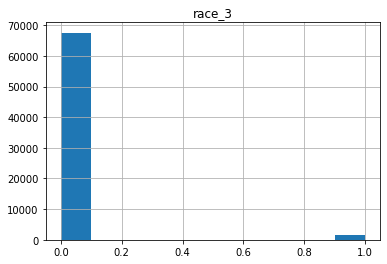

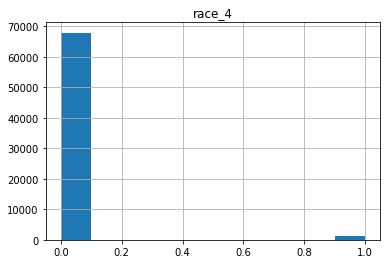

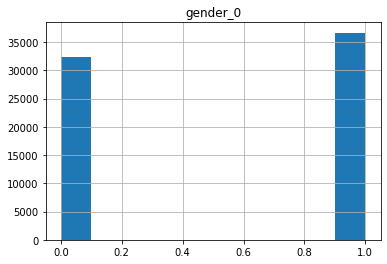

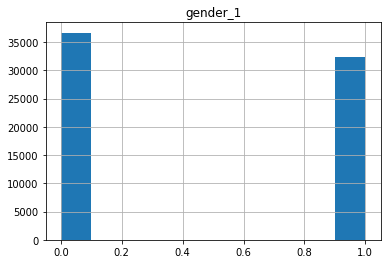

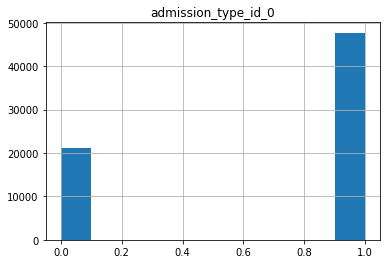

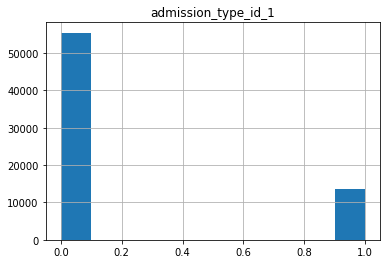

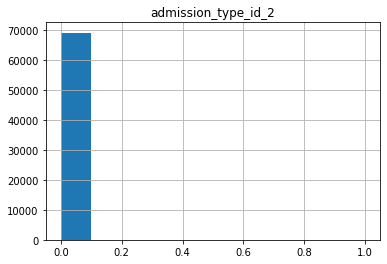

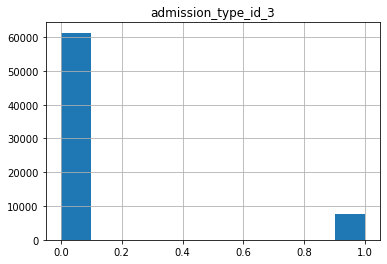

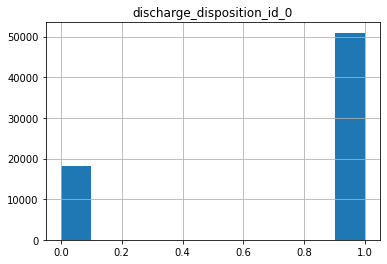

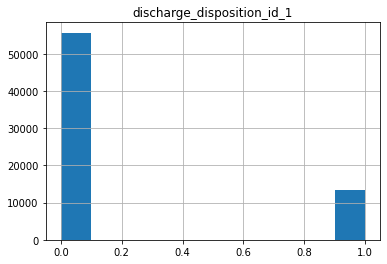

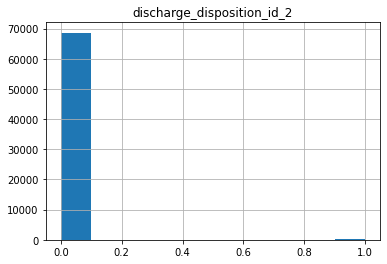

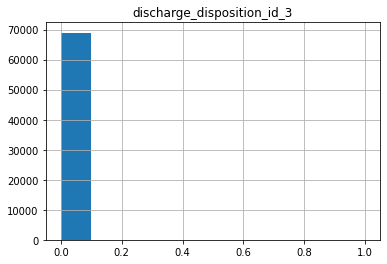

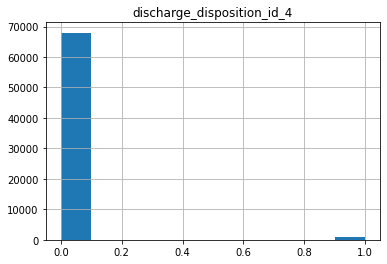

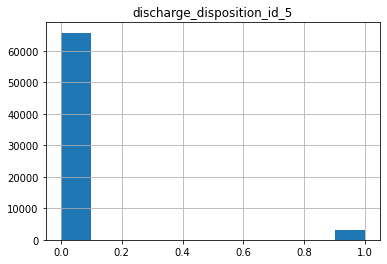

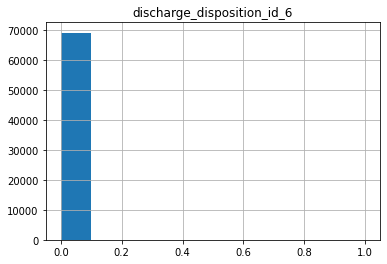

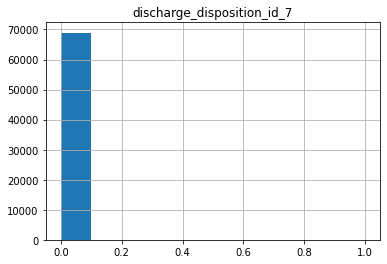

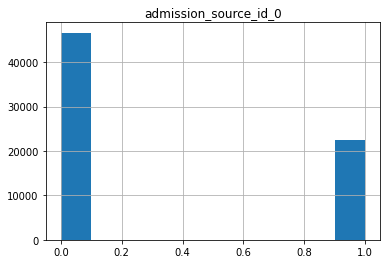

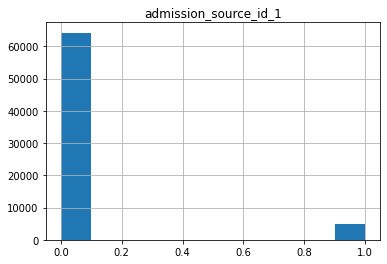

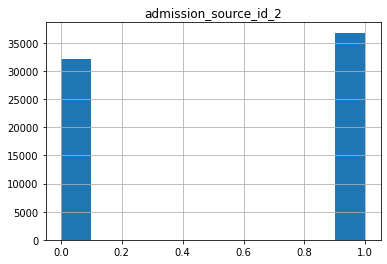

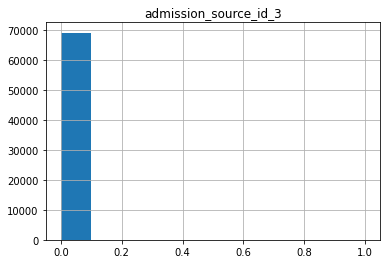

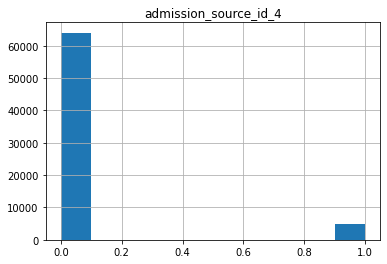

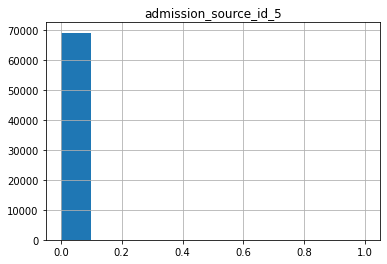

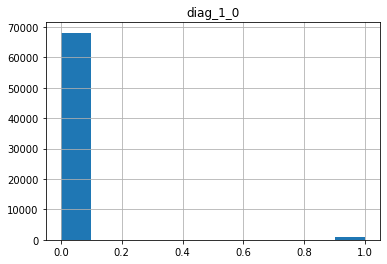

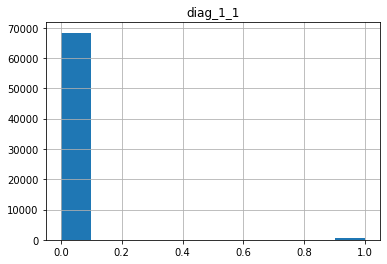

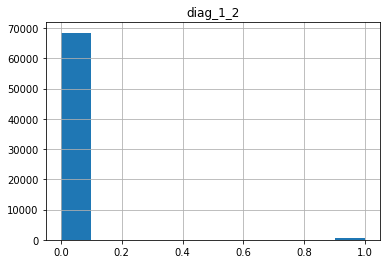

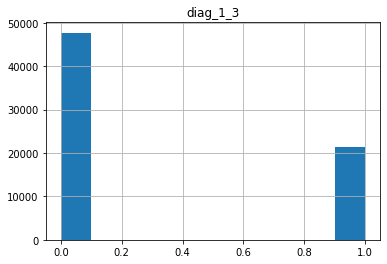

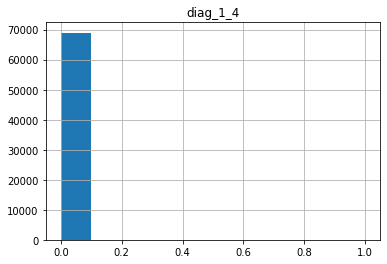

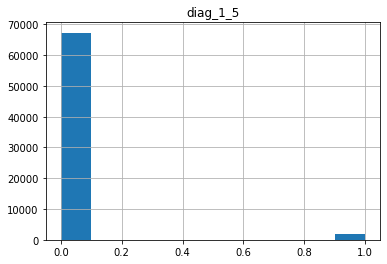

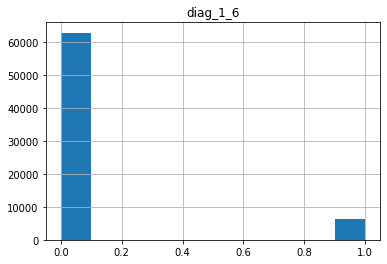

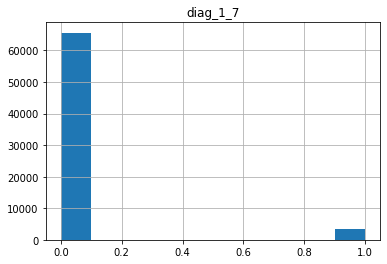

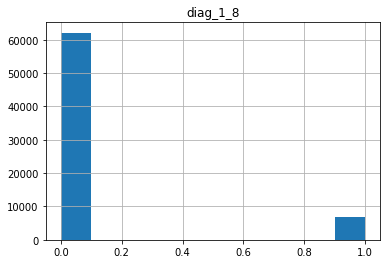

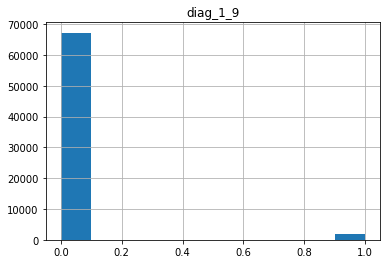

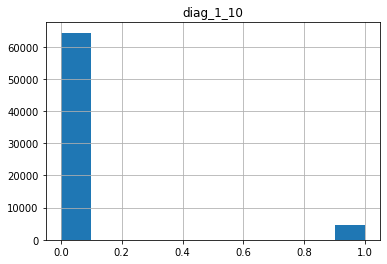

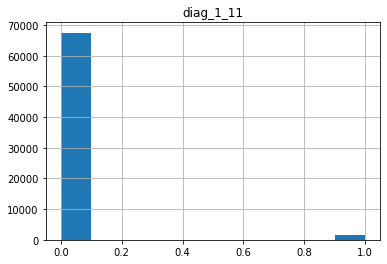

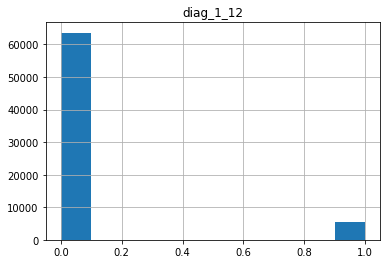

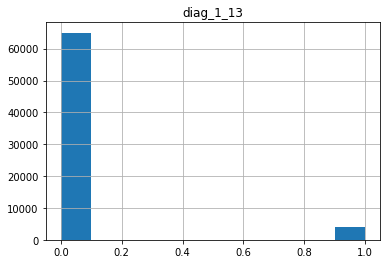

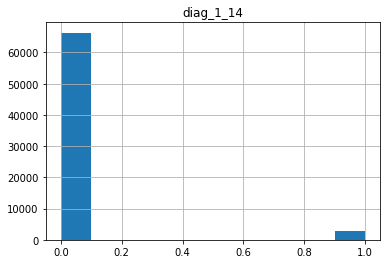

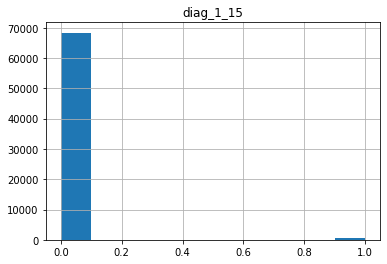

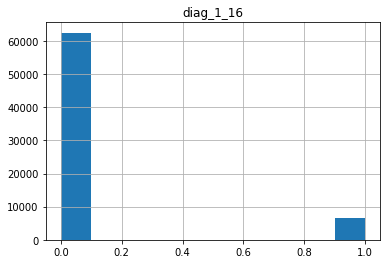

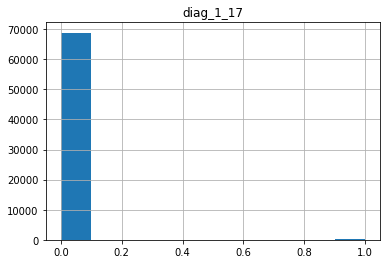

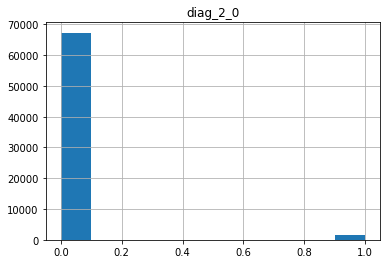

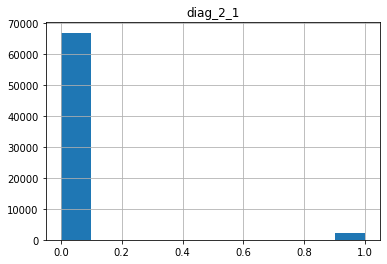

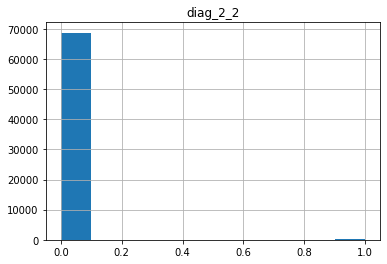

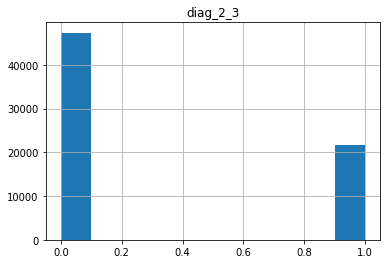

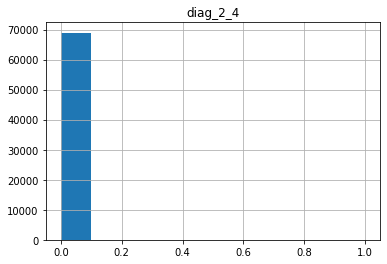

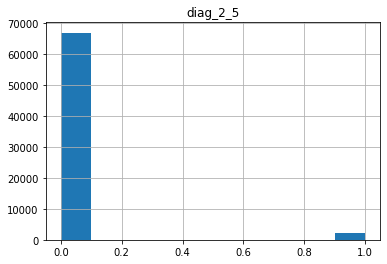

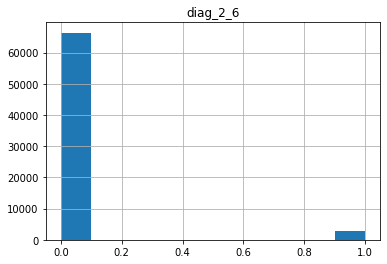

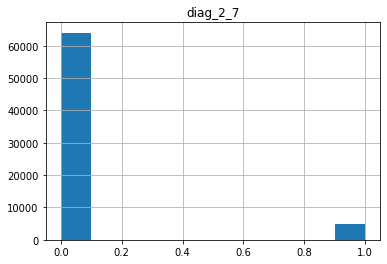

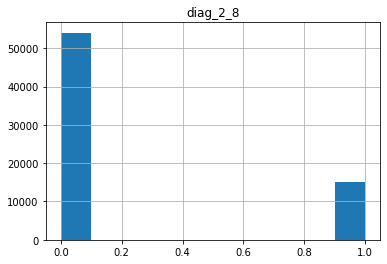

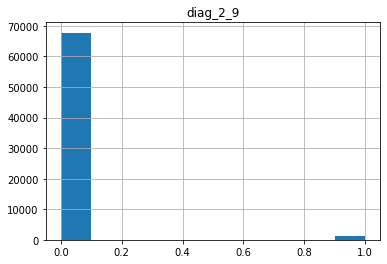

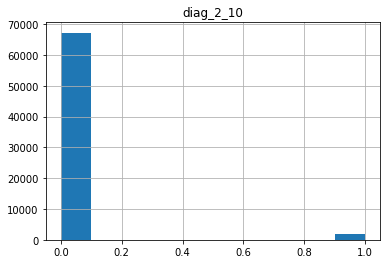

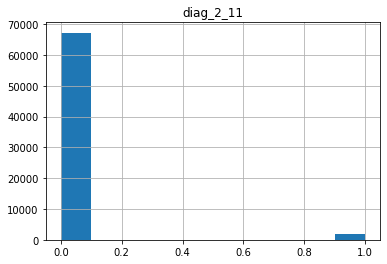

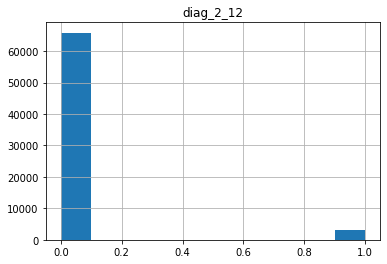

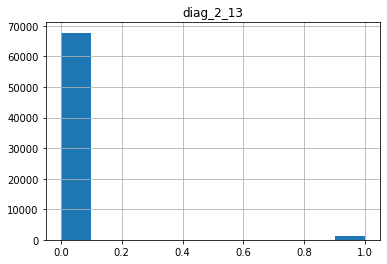

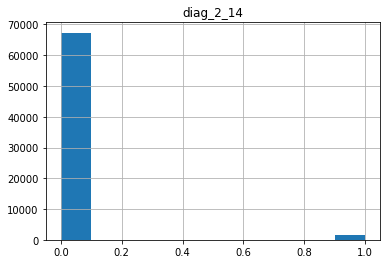

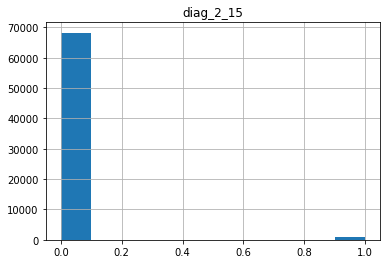

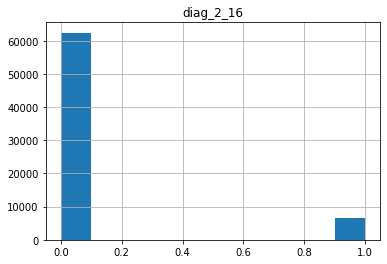

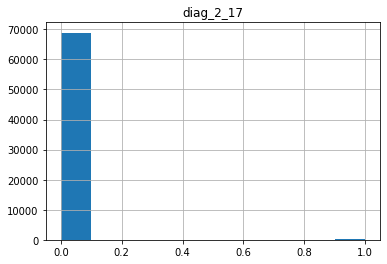

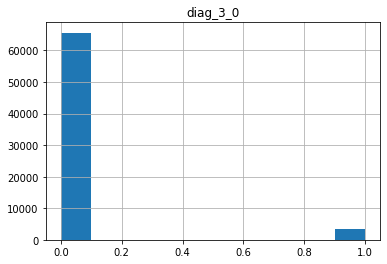

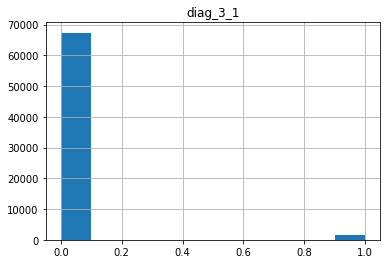

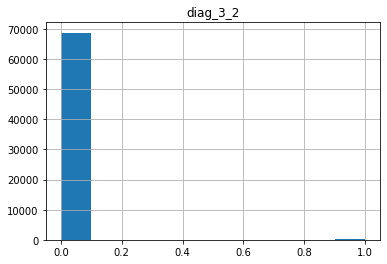

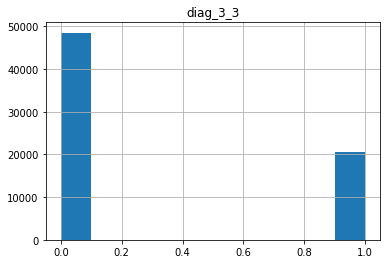

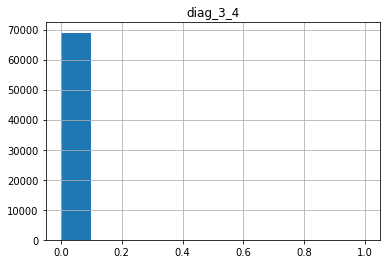

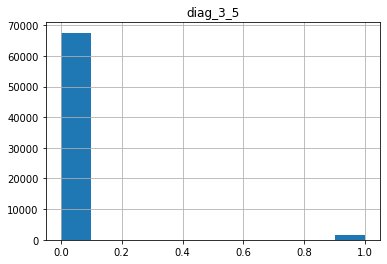

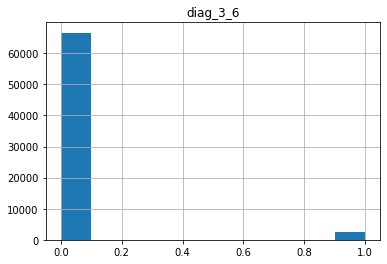

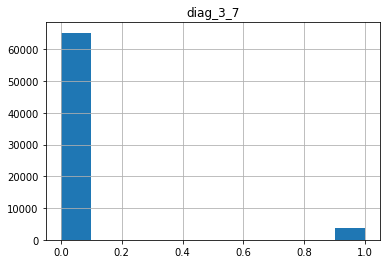

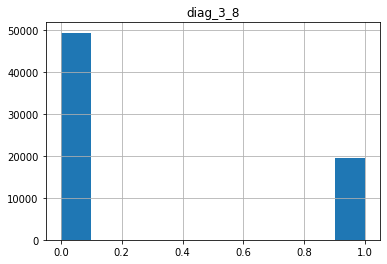

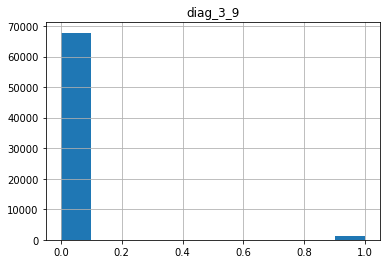

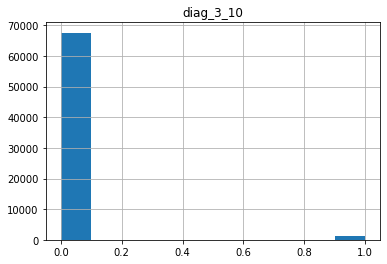

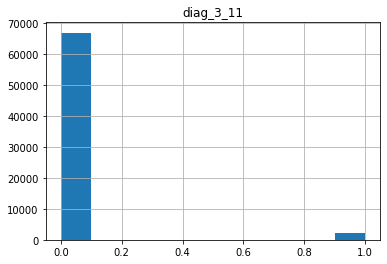

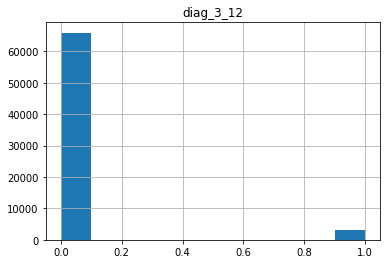

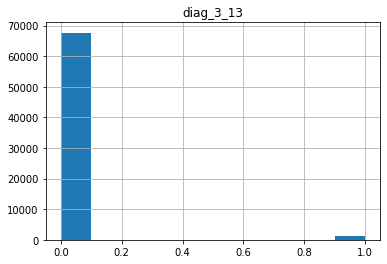

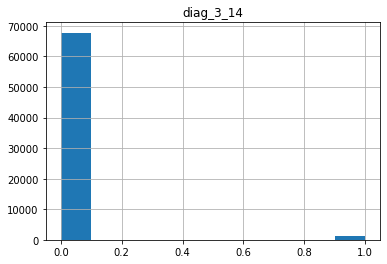

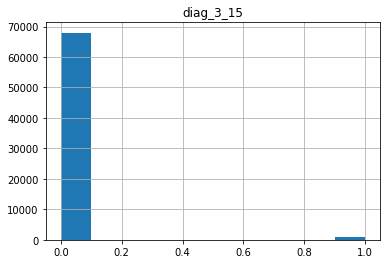

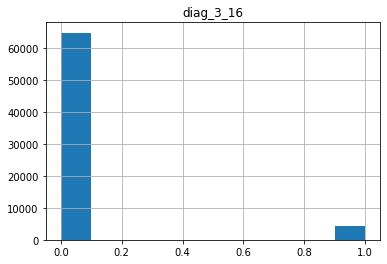

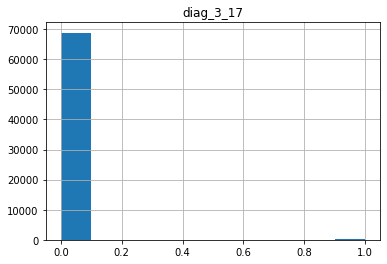

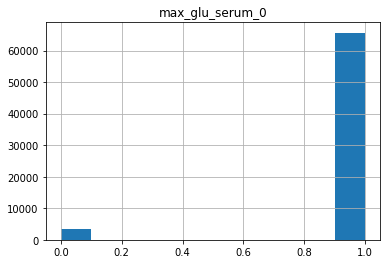

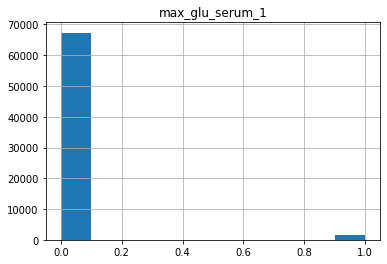

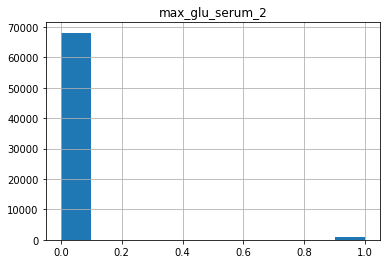

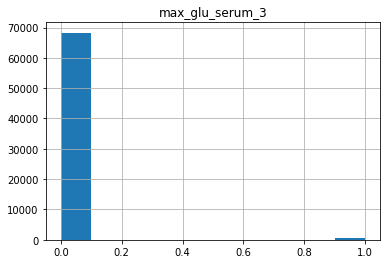

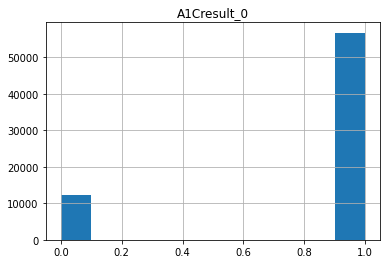

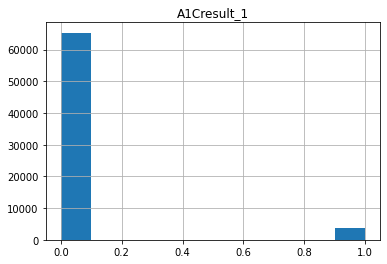

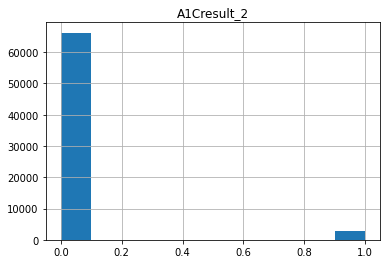

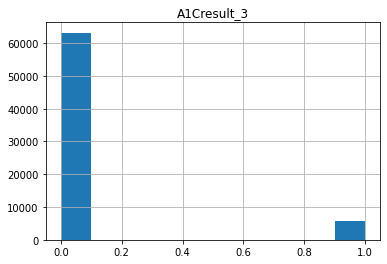

In [ ]:
import matplotlib. pyplot as plt

for i in range(state_data.shape[1]):
  fig, axes = plt.subplots(1, 1)
  state_data.hist(state_data.columns[i],ax=axes)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefa321b250>]],
      dtype=object)

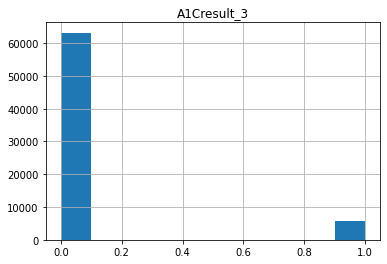

In [ ]:
state_data.hist(state_data.columns[i])

## Process action data

In [38]:
action_data_temp = action_data.copy()

### Just insulin [NO; STEADY; UP; DOWN]

In [43]:
action_data["insulin"].value_counts()

No        34089
Steady    21247
Down       7143
Up         6532
Name: insulin, dtype: int64

In [39]:
labels_one_hot = []
for val in action_data["insulin"]:
    v = [0] * 4
    if val == "No":
        v[0] = 1
    elif val == "Steady":
        v[1] = 1
    elif val == "Up":
        v[2] = 1
    elif val == "Down":
        v[3] = 1
    else:
        print("ERR")
    labels_one_hot.append(v)

In [ ]:
len(labels_one_hot)

In [ ]:
labels_one_hot[0]

### Generate unqie labels for actions

In [40]:
action_indexes = []
for action in labels_one_hot:
    action_indexes.append(action.index(1))

## Feature selection

In [42]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
features_to_delete = []
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
            features_to_delete.append(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)


In [43]:
chi_data =  state_data.copy()
chi_data["label"] = action_indexes
chi_data

,age,health_index,severity_of_disease,race_0,race_1,race_2,race_3,race_4,gender_0,gender_1,...,diag_3_17,max_glu_serum_0,max_glu_serum_1,max_glu_serum_2,max_glu_serum_3,A1Cresult_0,A1Cresult_1,A1Cresult_2,A1Cresult_3,label
0,0.428571,1.0,0.880282,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.428571,1.0,0.415493,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.857143,1.0,0.697183,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.857143,1.0,0.500000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.142857,1.0,0.387324,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69006,0.857143,1.0,0.619718,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
69007,0.571429,1.0,0.478873,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
69008,0.857143,1.0,0.436620,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
69009,0.285714,1.0,0.683099,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3


In [44]:
#Initialize ChiSquare Class
cT = ChiSquare(chi_data)

#Feature Selection
testColumns = chi_data.columns.values
for var in testColumns:
    cT.TestIndependence(colX=var,colY="label" ) 

age is IMPORTANT for Prediction
health_index is IMPORTANT for Prediction
severity_of_disease is IMPORTANT for Prediction
race_0 is IMPORTANT for Prediction
race_1 is IMPORTANT for Prediction
race_2 is IMPORTANT for Prediction
race_3 is NOT an important predictor. (Discard race_3 from model)
race_4 is IMPORTANT for Prediction
gender_0 is NOT an important predictor. (Discard gender_0 from model)
gender_1 is NOT an important predictor. (Discard gender_1 from model)
admission_type_id_0 is IMPORTANT for Prediction
admission_type_id_1 is IMPORTANT for Prediction
admission_type_id_2 is NOT an important predictor. (Discard admission_type_id_2 from model)
admission_type_id_3 is IMPORTANT for Prediction
discharge_disposition_id_0 is IMPORTANT for Prediction
discharge_disposition_id_1 is IMPORTANT for Prediction
discharge_disposition_id_2 is NOT an important predictor. (Discard discharge_disposition_id_2 from model)
discharge_disposition_id_3 is IMPORTANT for Prediction
discharge_disposition_id_4

In [50]:
state_data_temp = state_data.copy()

In [45]:
state_data = state_data.drop(['race_3', 'gender_0', 'gender_1','admission_type_id_2','discharge_disposition_id_2','discharge_disposition_id_7','discharge_disposition_id_7','admission_source_id_3',
                      'admission_source_id_5','diag_1_4','diag_1_7','diag_1_10','diag_1_15','diag_1_17','diag_2_2','diag_2_4','diag_2_6','diag_2_10','diag_2_15','diag_2_17','diag_3_2','diag_3_4',
                      'diag_3_6','diag_3_11','diag_3_12','diag_3_14','diag_3_15','diag_3_17','A1Cresult_1'],axis=1)

In [69]:
state_counts = state_data[["health_index",  "severity_of_disease"#,  "max_glu_serum_0",  "max_glu_serum_1",  "max_glu_serum_2",  "max_glu_serum_3",  "A1Cresult_0",  "A1Cresult_2",  "A1Cresult_3"
    ]].value_counts()
    
state_counts[state_counts < 2].index.tolist()

[(0.0, 0.07746478873239436),
 (0.0, 0.04929577464788733),
 (0.0, 0.8028169014084507),
 (0.25, 0.9436619718309859),
 (0.5, 0.9788732394366197),
 (0.75, 0.0),
 (0.75, 0.01408450704225352),
 (0.5, 0.042253521126760556),
 (0.5, 0.0352112676056338),
 (0.5, 0.02816901408450704),
 (0.5, 0.021126760563380285),
 (0.25, 0.9929577464788732),
 (0.25, 0.9859154929577465),
 (0.25, 0.9647887323943662),
 (0.25, 0.936619718309859),
 (0.0, 0.908450704225352),
 (0.25, 0.8943661971830985),
 (0.25, 0.8732394366197183),
 (0.25, 0.852112676056338),
 (0.25, 0.04929577464788733),
 (0.25, 0.021126760563380285),
 (0.0, 0.9859154929577465),
 (0.0, 0.9577464788732394),
 (0.0, 0.9436619718309859),
 (0.0, 0.936619718309859),
 (0.0, 0.9154929577464788),
 (0.0, 0.0352112676056338)]

## Training/testing 80/20 split 

In [ ]:
from collections import Counter
print(Counter(feedback_data))

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(state_data, action_indexes, test_size = 0.2, random_state=0, stratify=action_indexes)

In [47]:
num_arms = len(set(action_indexes))

In [48]:
X_train_RL = X_train.copy()
X_test_RL = X_test.copy()
Y_train_RL = []
Y_test_RL = []
for y in Y_train:
    one_hot_v = [0] * num_arms
    one_hot_v[y] = 1
    Y_train_RL.append(one_hot_v)
for y in Y_test:
    one_hot_v = [0] * num_arms
    one_hot_v[y] = 1
    Y_test_RL.append(one_hot_v)

## Treat imbalanced data

In [51]:
import imblearn

Class=1, n=21247 (30.788%)
Class=0, n=34089 (49.396%)
Class=3, n=7143 (10.351%)
Class=2, n=6532 (9.465%)


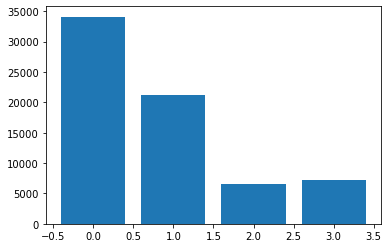

In [52]:
from matplotlib import pyplot
counter = Counter(action_indexes)
for k,v in counter.items():
	per = v / len(action_indexes) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [56]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X_resampled, Y_resampled = undersample.fit_resample(state_data, action_indexes)

In [57]:
X_resampled_train, X_resampled_test, Y_resampled_train, Y_resampled_test = train_test_split(X_resampled, Y_resampled, test_size = 0.2, random_state=0, stratify=Y_resampled)

In [58]:
X_resampled_train_RL = X_resampled_train.copy()
X_resampled_test_RL = X_resampled_test.copy()
Y_resampled_train_RL = []
Y_resampled_test_RL = []
for y in Y_resampled_train:
    one_hot_v = [0] * num_arms
    one_hot_v[y] = 1
    Y_resampled_train_RL.append(one_hot_v)
for y in Y_resampled_test:
    one_hot_v = [0] * num_arms
    one_hot_v[y] = 1
    Y_resampled_test_RL.append(one_hot_v)

# Reinforcement learning

## Naive MAB

In [ ]:
np.zeros(9)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

Policy

In [ ]:
class Policy(object):
    """
    A policy prescribes an action to be taken based on the memory of an agent.
    """
    def __str__(self):
        return 'generic policy'

    def choose(self, agent):
        return 0


class EpsilonGreedyPolicy(Policy):
    """
    The Epsilon-Greedy policy will choose a random action with probability
    epsilon and take the best apparent approach with probability 1-epsilon. If
    multiple actions are tied for best choice, then a random action from that
    subset is selected.
    """
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, agent, state):
        if state not in agent.s_a_estimates:
            agent.s_a_estimates[state] = np.zeros(2)
            agent.action_counts[state] = np.zeros(2)
            #print(state)
            return np.random.choice(2)#(9)
        action_ests = agent.s_a_estimates[state]
        if np.random.random() < self.epsilon:
            return np.random.choice(len(action_ests))
        else:
            action = np.argmax(action_ests)
            #print("--optimal")
            return action
            # check = np.where(action_ests == action_ests[action])[0]
            # if len(check) == 1:
            #     return action
            # else:
            #     return np.random.choice(check)

    def choose_test(self, agent, state):
        if state not in agent.s_a_estimates:
            return np.random.choice(2)#(9)
        action_ests = agent.s_a_estimates[state]
        action = np.argmax(action_ests)
        return action



Bandit

In [ ]:
class MultiArmedBandit(object):
    """
    A Multi-armed Bandit
    """
    def __init__(self, state_count = None, action_count = 2):
        self.state_count = state_count
        self.action_count = action_count

        self.curr_state = 0
        self.curr_patient_i = 0

    def reset(self):
        self.curr_state = 0
        self.curr_patient_i = 0

    def set_state_train(self, patient_data, patient_i):
        self.curr_state = patient_data
        self.curr_patient_i = patient_i

    def set_state_test(self, patient_data, patient_i):
        self.curr_state = patient_data
        self.curr_patient_i = patient_i

    def get_state(self):
        return self.curr_state

    # returning reward
    def pull_train(self, action):
        reward = 0

        if action == np.array(Y_train)[self.curr_patient_i]:
            reward = 1
        else: 
            reward = 0
        return reward

    def pull_test(self, action):

        accuracy = 0

        opt_action = np.array(Y_test)[self.curr_patient_i]
        if action == opt_action:
            accuracy = 1
        else:
            accuracy = 0

        return accuracy


Agent

In [ ]:
class Agent(object):
    """
    An Agent is able to take one of a set of actions at each time step. The
    action is chosen using a strategy based on the history of prior actions
    and outcome observations.
    """
    def __init__(self, bandit, policy, gamma=None):
        self.policy = policy
        self.state_count = bandit.state_count
        self.action_count = bandit.action_count
        self.s_a_estimates = {}
        self.action_counts = {}
        self.t = 0
        self.state = None
        self.action = None

    def __str__(self):
        return 'f/{}'.format(str(self.policy))

    def reset(self):
        """
        Resets the agent's memory to an initial state.
        """
        self.s_a_estimates = {}
        self.action_counts = {}
        self.action = None
        self.state = None
        self.t = 0

    def choose(self, state):
        self.state = state
        action = self.policy.choose(self, state)
        self.action = action
        return action

    def choose_test(self, state):
        self.state = state
        action = self.policy.choose_test(self, state)
        self.action = action
        return action

    def observe(self, reward):
        self.action_counts[self.state][self.action] += 1

        if self.gamma is None:
            g = 1 / self.action_counts[self.state][self.action]
        else:
            g = self.gamma
        q = self.s_a_estimates[self.state][self.action]

        self.s_a_estimates[self.state][self.action] += g*(reward - q)
        self.t += 1


Environment / train

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import random

class Env(object):
    def __init__(self, bandit, agents, label=''):
        self.bandit = bandit
        self.agents = agents
        self.label = label
        self.learned_ests = [None] * len(agents)

    def reset(self):
        self.bandit.reset()
        for agent in self.agents:
            agent.reset()

    def run_train(self, data, experiments=1):
        scores = np.zeros((len(data), len(self.agents)))

        for e in range(experiments):
            self.reset()
            patient_is = list(range(len(data)))
            random.shuffle(patient_is)
            t = 0
            for patient_i in patient_is:
                patient_data = data[patient_i].reshape(1, -1)
                self.bandit.set_state_train(str(patient_data), patient_i)
                state = self.bandit.get_state()
                for i, agent in enumerate(self.agents):
                    action = agent.choose(state)
                    reward = self.bandit.pull_train(action)
                    agent.observe(reward)

                    scores[t, i] += reward
                
                t = t+1
            
        return scores / experiments

    def run_test(self, data, experiments=1):
        scores = np.zeros((len(data), len(self.agents)))
        
        for _ in range(experiments):
            self.reset()
            patient_is = list(range(len(data)))
            random.shuffle(patient_is)
            t = 0
            for patient_i in patient_is:
                patient_data = data[patient_i].reshape(1, -1)
                self.bandit.set_state_test(str(patient_data), patient_i)
                state = self.bandit.get_state()
                for i, agent in enumerate(self.agents):
                    action = agent.choose_test(state)
                    accuracy = self.bandit.pull_test(action)

                    scores[t, i] += accuracy
                
                t = t+1

        return scores / experiments

    def plot_results(self, scores):
        sns.set_style('white')
        sns.set_context('talk')
        plt.title(self.label)
        plt.plot(scores)
        plt.ylabel('Average Reward')
        plt.legend(self.agents, loc=4)
        sns.despine()
        plt.show()

    def plot_test_results(self, scores):
        sns.set_style('white')
        sns.set_context('talk')
        plt.title(self.label)
        plt.plot(scores)
        plt.ylabel('Testing Accuracy')
        plt.legend(self.agents, loc=4)
        sns.despine()
        plt.show()


Put everything together

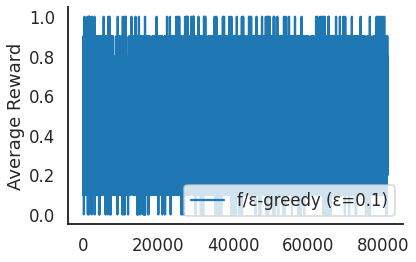

In [ ]:
import matplotlib.pyplot as plt
import pymc3 as pm

# label = 'train'
bandit = MultiArmedBandit(2)
agents = [
    #Agent(bandit, EpsilonGreedyPolicy(0.01)),
    Agent(bandit, EpsilonGreedyPolicy(0.1)),
]
env = Env(bandit, agents)
scores = env.run_train(np.array(X_train), 10)
env.plot_results(scores)



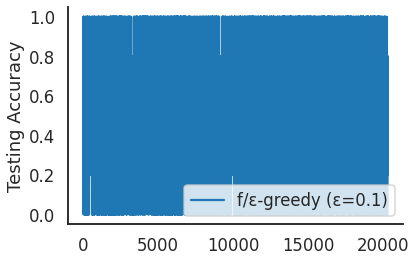

In [ ]:
test_scores = env.run_test(np.array(X_test), 5)
env.plot_test_results(test_scores)

In [ ]:
sum(test_scores)/len(test_scores)

array([0.50090739])

## Contextual MAB

In [55]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer, LinUCB
from contextualbandits.evaluation import evaluateFullyLabeled 
from copy import deepcopy

In [59]:
X_train_RL = np.array(X_train_RL)
X_test_RL = np.array(X_test_RL)

X_resampled_train_RL = np.array(X_resampled_train_RL)
X_resampled_test_RL = np.array(X_resampled_test_RL) 

In [ ]:
np.array(Y_train_RL).shape[1]

4

In [ ]:
X_train_RL.shape

(55208, 12)

In [ ]:
np.vstack((X_train_RL, X_test_RL))[:, 0]

array([0.  , 0.  , 0.5 , ..., 0.75, 0.5 , 0.5 ])

In [ ]:
np.vstack((X_train_RL, X_test_RL))[:, 0]

array([0.07853096, 0.07853096, 0.07853096, ..., 0.07853096, 0.07853096,
       0.07853096])

In [235]:
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True, max_iter=1000,)

nchoices = np.array(Y_train_RL).shape[1]

epsilon_greedy_random_e09999_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.9999, decay=0.1, nchoices = nchoices, # random policy
                               random_state = 1) 

explore_first = ExploreFirst(base_algorithm, nchoices, explore_rounds=25,#00, 
                             prob_active_choice=0.0, active_choice='weighted', 
                             f_grad_norm='auto', case_one_class='auto', beta_prior=None, 
                             smoothing=None, noise_to_smooth=True, batch_train=False, 
                             refit_buffer=None, deep_copy_buffer=True, assume_unique_reward=False, 
                             random_state=None, njobs=- 1)

epsilon_greedy_e09_a09 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.9, decay=0.9, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e09_a05 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.9, decay=0.5, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e09_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.9, decay=0.1, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e05_a09 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.5, decay=0.9, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e05_a05 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.5, decay=0.5, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e05_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.5, decay=0.1, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e01_a09 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.1, decay=0.9, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e01_a05 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.1, decay=0.5, nchoices = nchoices, 
                               random_state = 1) 

epsilon_greedy_e01_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.1, decay=0.1, nchoices = nchoices, 
                               random_state = 1) 

# epsilon_greedy_e005_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.05, decay=0.1, nchoices = nchoices, 
#                                random_state = 1) 
epsilon_greedy_e001_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.01, decay=0.1, nchoices = nchoices, 
                               random_state = 1) 
epsilon_greedy_e0001_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.001, decay=0.1, nchoices = nchoices, 
                                random_state = 1) 
# epsilon_greedy_e00001_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.0001, decay=0.1, nchoices = nchoices, 
#                                random_state = 1) 
# epsilon_greedy_e000001_a01 = EpsilonGreedy(deepcopy(base_algorithm), explore_prob=0.00001, decay=0.1, nchoices = nchoices, 
#                                random_state = 1) 

lin_ucb_a09_nu = LinUCB(nchoices, alpha=0.9, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=False, random_state=1, njobs=1)

lin_ucb_a05_nu = LinUCB(nchoices, alpha=0.5, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=False, random_state=1, njobs=1)

lin_ucb_a01_nu = LinUCB(nchoices, alpha=0.1, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=False, random_state=1, njobs=1)

lin_ucb_a09_u = LinUCB(nchoices, alpha=0.9, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=True, random_state=1, njobs=1)

lin_ucb_a05_u = LinUCB(nchoices, alpha=0.5, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=True, random_state=1, njobs=1)

lin_ucb_a01_u = LinUCB(nchoices, alpha=0.1, lambda_=1, 
                 fit_intercept=True, use_float=True, 
                 method='sm', ucb_from_empty=True, beta_prior=None, 
                 smoothing=None, noise_to_smooth=True, 
                 assume_unique_reward=True, random_state=1, njobs=1)

boot_ucb_s10_p80 = BootstrappedUCB(base_algorithm, nchoices, nsamples=10, percentile=80, 
                beta_prior='auto', smoothing=None, noise_to_smooth=True, 
                batch_train=False, refit_buffer=None, deep_copy_buffer=True, 
                assume_unique_reward=False, batch_sample_method='gamma', 
                random_state=None, njobs_arms=- 1, njobs_samples=1)

boot_ucb_s10_p50 = BootstrappedUCB(base_algorithm, nchoices, nsamples=10, percentile=50, 
                beta_prior='auto', smoothing=None, noise_to_smooth=True, 
                batch_train=False, refit_buffer=None, deep_copy_buffer=True, 
                assume_unique_reward=False, batch_sample_method='gamma', 
                random_state=None, njobs_arms=- 1, njobs_samples=1)

boot_ucb_s10_p20 = BootstrappedUCB(base_algorithm, nchoices, nsamples=10, percentile=20, 
                beta_prior='auto', smoothing=None, noise_to_smooth=True, 
                batch_train=False, refit_buffer=None, deep_copy_buffer=True, 
                assume_unique_reward=False, batch_sample_method='gamma', 
                random_state=None, njobs_arms=- 1, njobs_samples=1)

boot_ucb_s15_p50 = BootstrappedUCB(base_algorithm, nchoices, nsamples=15, percentile=50, 
                beta_prior='auto', smoothing=None, noise_to_smooth=True, 
                batch_train=False, refit_buffer=None, deep_copy_buffer=True, 
                assume_unique_reward=False, batch_sample_method='gamma', 
                random_state=None, njobs_arms=- 1, njobs_samples=1)

boot_ucb_s5_p50 = BootstrappedUCB(base_algorithm, nchoices, nsamples=5, percentile=50, 
                beta_prior='auto', smoothing=None, noise_to_smooth=True, 
                batch_train=False, refit_buffer=None, deep_copy_buffer=True, 
                assume_unique_reward=False, batch_sample_method='gamma', 
                random_state=None, njobs_arms=- 1, njobs_samples=1)



models = [

epsilon_greedy_random_e09999_a01,
explore_first ,
epsilon_greedy_e09_a01 ,
epsilon_greedy_e05_a01 ,
epsilon_greedy_e01_a01 ,
epsilon_greedy_e001_a01,
lin_ucb_a09_nu ,
lin_ucb_a05_nu ,
lin_ucb_a01_nu ,
boot_ucb_s10_p80 ,
boot_ucb_s10_p50 ,
boot_ucb_s10_p20,
boot_ucb_s15_p50,
boot_ucb_s5_p50

]

/opt/homebrew/Caskroom/miniforge/base/envs/apress/lib/python3.9/site-packages/contextualbandits/online.py:1515: UserWarning: Warning: 'EpsilonGreedy' has a very high decay rate.
  warnings.warn("Warning: 'EpsilonGreedy' has a very high decay rate.")


In [236]:
# batch size - algorithms will be refit after N rounds
batch_size = 200

In [234]:
X_resampled_train_RL.shape

(20902, 62)

In [239]:
# X = np.array(X_train_RL)
# Y = np.array(Y_train_RL)

X = np.array(X_resampled_train_RL)
Y = np.array(Y_resampled_train_RL)

# X = np.vstack((X_train_RL, X_test_RL))
# Y = np.vstack((Y_train_RL, Y_test_RL))

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
# print(action_chosen)
rewards_received = Y[np.arange(batch_size), action_chosen]
# print(rewards_received)

# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

# keep track of the rewards obtained by each policy
rewards_epsilon_greedy_random_e09999_a01 = list()
rewards_explore_first = list()
rewards_epsilon_greedy_e09_a01 = list()
rewards_epsilon_greedy_e05_a01 = list()
rewards_epsilon_greedy_e01_a01 = list()
rewards_epsilon_greedy_e001_a01 = list()
rewards_lin_ucb_a09_nu = list()
rewards_lin_ucb_a05_nu = list()
rewards_lin_ucb_a01_nu = list()
rewards_boot_ucb_s10_p80 = list()
rewards_boot_ucb_s10_p50 = list()
rewards_boot_ucb_s10_p20 = list()
rewards_boot_ucb_s15_p50 = list()
rewards_boot_ucb_s5_p50 = list()

lst_rewards = [
rewards_epsilon_greedy_random_e09999_a01,
rewards_explore_first ,
rewards_epsilon_greedy_e09_a01 ,
rewards_epsilon_greedy_e05_a01 ,
rewards_epsilon_greedy_e01_a01 ,
rewards_epsilon_greedy_e001_a01, 
rewards_lin_ucb_a09_nu ,
rewards_lin_ucb_a05_nu ,
rewards_lin_ucb_a01_nu ,
rewards_boot_ucb_s10_p80 ,
rewards_boot_ucb_s10_p50 ,
rewards_boot_ucb_s10_p20,
rewards_boot_ucb_s15_p50,
rewards_boot_ucb_s5_p50
]

# keep track of which actions does each policy choose
lst_a_epsilon_greedy_random_e09999_a01 = action_chosen.copy()
lst_a_explore_first = action_chosen.copy()
lst_a_epsilon_greedy_e09_a01 = action_chosen.copy()
lst_a_epsilon_greedy_e05_a01 = action_chosen.copy()
lst_a_epsilon_greedy_e01_a01 = action_chosen.copy()
lst_a_epsilon_greedy_e001_a01 = action_chosen.copy()
lst_a_lin_ucb_a09_nu = action_chosen.copy()
lst_a_lin_ucb_a05_nu = action_chosen.copy()
lst_a_lin_ucb_a01_nu = action_chosen.copy()
lst_a_boot_ucb_s10_p80 = action_chosen.copy()
lst_a_boot_ucb_s10_p50 = action_chosen.copy()
lst_a_boot_ucb_s10_p20 = action_chosen.copy()
lst_a_boot_ucb_s15_p50 = action_chosen.copy()
lst_a_boot_ucb_s5_p50 = action_chosen.copy()

lst_actions = [
lst_a_epsilon_greedy_random_e09999_a01,
lst_a_explore_first ,
lst_a_epsilon_greedy_e09_a01 ,
lst_a_epsilon_greedy_e05_a01 ,
lst_a_epsilon_greedy_e01_a01 ,
lst_a_epsilon_greedy_e001_a01, 
lst_a_lin_ucb_a09_nu ,
lst_a_lin_ucb_a05_nu ,
lst_a_lin_ucb_a01_nu ,
lst_a_boot_ucb_s10_p80 ,
lst_a_boot_ucb_s10_p50 ,
lst_a_boot_ucb_s10_p20,
lst_a_boot_ucb_s15_p50,
lst_a_boot_ucb_s5_p50
]


9

In [240]:

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
              warm_start = True)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, Y,
                                             batch_st, batch_end)

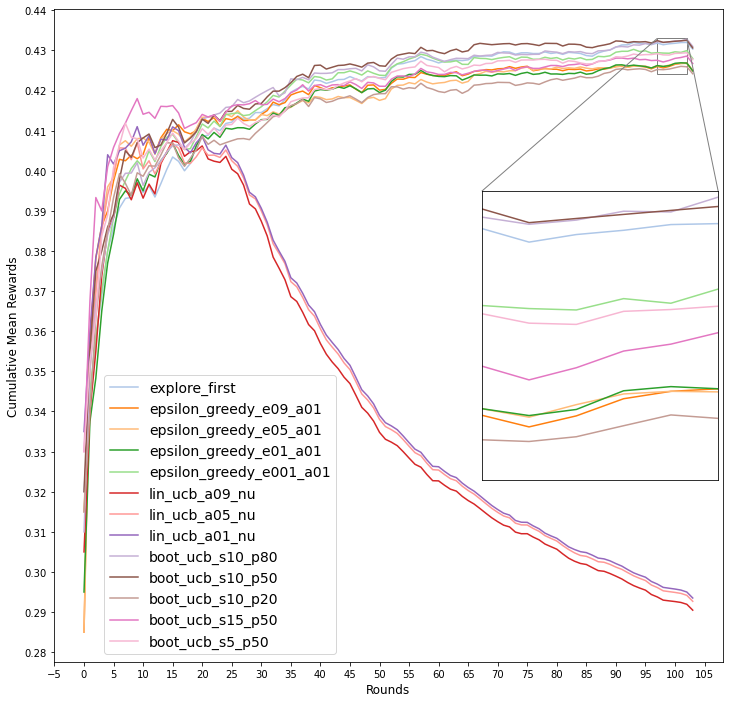

In [282]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from pylab import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

colors=plt.cm.tab20(np.linspace(0, 1, 20))

tick_spacing = 5

fig, ax = plt.subplots(1,1, figsize=(12,12))

#plt.figure(figsize=(10,10))
# ax.plot(get_mean_reward(rewards_epsilon_greedy_random_e09999_a01), label="epsilon_greedy_random_e09999_a01", color=colors[0])
ax.plot(get_mean_reward(rewards_explore_first), label="explore_first", color=colors[1])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e09_a09), label="epsilon_greedy_e09_a09", color=colors[2])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e09_a05), label="epsilon_greedy_e09_a05", color=colors[3])
ax.plot(get_mean_reward(rewards_epsilon_greedy_e09_a01), label="epsilon_greedy_e09_a01", color=colors[2])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e05_a09), label="epsilon_greedy_e05_a09", color=colors[5])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e05_a05), label="epsilon_greedy_e05_a05", color=colors[6])
ax.plot(get_mean_reward(rewards_epsilon_greedy_e05_a01), label="epsilon_greedy_e05_a01", color=colors[3])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e01_a09), label="epsilon_greedy_e01_a09", color=colors[8])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e01_a05), label="epsilon_greedy_e01_a05", color=colors[9])
ax.plot(get_mean_reward(rewards_epsilon_greedy_e01_a01), label="epsilon_greedy_e01_a01", color=colors[4])
ax.plot(get_mean_reward(rewards_epsilon_greedy_e001_a01), label="epsilon_greedy_e001_a01", color=colors[5])
ax.plot(get_mean_reward(rewards_lin_ucb_a09_nu), label="lin_ucb_a09_nu", color=colors[6])
ax.plot(get_mean_reward(rewards_lin_ucb_a05_nu), label="lin_ucb_a05_nu", color=colors[7])
ax.plot(get_mean_reward(rewards_lin_ucb_a01_nu), label="lin_ucb_a01_nu", color=colors[8])
ax.plot(get_mean_reward(rewards_boot_ucb_s10_p80), label="boot_ucb_s10_p80", color=colors[9])
ax.plot(get_mean_reward(rewards_boot_ucb_s10_p50), label="boot_ucb_s10_p50", color=colors[10])
ax.plot(get_mean_reward(rewards_boot_ucb_s10_p20), label="boot_ucb_s10_p20", color=colors[11])
ax.plot(get_mean_reward(rewards_boot_ucb_s15_p50), label="boot_ucb_s15_p50", color=colors[12])
ax.plot(get_mean_reward(rewards_boot_ucb_s5_p50), label="boot_ucb_s5_p50", color=colors[13])

# ax.plot(get_mean_reward(rewards_epsilon_greedy_e005_a01), label="epsilon_greedy_e005_a01")
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e0001_a01), label="epsilon_greedy_e0001_a01")
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e00001_a01), label="epsilon_greedy_e00001_a01")
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e000001_a01), label="epsilon_greedy_e000001_a01")

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))

axins = zoomed_inset_axes(ax, 8, loc=5) # zoom = 6

# axins.plot(get_mean_reward(rewards_epsilon_greedy_random_e09999_a01), label="epsilon_greedy_random_e09999_a01", color=colors[0])
axins.plot(get_mean_reward(rewards_explore_first), label="explore_first", color=colors[1])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e09_a09), label="epsilon_greedy_e09_a09", color=colors[2])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e09_a05), label="epsilon_greedy_e09_a05", color=colors[3])
axins.plot(get_mean_reward(rewards_epsilon_greedy_e09_a01), label="epsilon_greedy_e09_a01", color=colors[2])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e05_a09), label="epsilon_greedy_e05_a09", color=colors[5])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e05_a05), label="epsilon_greedy_e05_a05", color=colors[6])
axins.plot(get_mean_reward(rewards_epsilon_greedy_e05_a01), label="epsilon_greedy_e05_a01", color=colors[3])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e01_a09), label="epsilon_greedy_e01_a09", color=colors[8])
# ax.plot(get_mean_reward(rewards_epsilon_greedy_e01_a05), label="epsilon_greedy_e01_a05", color=colors[9])
axins.plot(get_mean_reward(rewards_epsilon_greedy_e01_a01), label="epsilon_greedy_e01_a01", color=colors[4])
axins.plot(get_mean_reward(rewards_epsilon_greedy_e001_a01), label="epsilon_greedy_e001_a01", color=colors[5])
axins.plot(get_mean_reward(rewards_lin_ucb_a09_nu), label="lin_ucb_a09_nu", color=colors[6])
axins.plot(get_mean_reward(rewards_lin_ucb_a05_nu), label="lin_ucb_a05_nu", color=colors[7])
axins.plot(get_mean_reward(rewards_lin_ucb_a01_nu), label="lin_ucb_a01_nu", color=colors[8])
axins.plot(get_mean_reward(rewards_boot_ucb_s10_p80), label="boot_ucb_s10_p80", color=colors[9])
axins.plot(get_mean_reward(rewards_boot_ucb_s10_p50), label="boot_ucb_s10_p50", color=colors[10])
axins.plot(get_mean_reward(rewards_boot_ucb_s10_p20), label="boot_ucb_s10_p20", color=colors[11])
axins.plot(get_mean_reward(rewards_boot_ucb_s15_p50), label="boot_ucb_s15_p50", color=colors[12])
axins.plot(get_mean_reward(rewards_boot_ucb_s5_p50), label="boot_ucb_s5_p50", color=colors[13])


axins.set_xlim(97, 102)
axins.set_ylim(0.424, 0.433)
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")
plt.draw()

ax.set_xlabel('Rounds', fontsize=12)
ax.set_ylabel('Cumulative Mean Rewards', fontsize=12)
ax.legend(bbox_to_anchor=(0.065,0.45), fontsize=14)
plt.show()



In [217]:
# unbalanced data
for i in range(len(models)):
    rl_pred = models[i].predict(np.array(X_test_RL))

    Test_Score = accuracy_score(np.array(Y_test), rl_pred)
    print(i, ': Testing Accuracy is:',Test_Score)

0 : Testing Accuracy is: 0.5073534738824893
1 : Testing Accuracy is: 0.5073534738824893
2 : Testing Accuracy is: 0.5073534738824893


In [242]:
# balanced data
for i in range(len(models)):
    rl_pred = models[i].predict(np.array(X_resampled_test_RL))

    Test_Score = accuracy_score(np.array(Y_resampled_test), rl_pred)
    print(i, ': Testing Accuracy is:',Test_Score)

0 : Testing Accuracy is: 0.44412552621507845
1 : Testing Accuracy is: 0.4435514734022197
2 : Testing Accuracy is: 0.4393417527745886
3 : Testing Accuracy is: 0.433027171833142
4 : Testing Accuracy is: 0.43455797933409873
5 : Testing Accuracy is: 0.4362801377726751
6 : Testing Accuracy is: 0.2500956754688098
7 : Testing Accuracy is: 0.2502870264064294
8 : Testing Accuracy is: 0.2502870264064294
9 : Testing Accuracy is: 0.4395331037122082
10 : Testing Accuracy is: 0.4393417527745886
11 : Testing Accuracy is: 0.44087256027554533
12 : Testing Accuracy is: 0.4395331037122082
13 : Testing Accuracy is: 0.4435514734022197


# Other Prediction models

## LR

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

In [77]:
X_train.shape

(55208, 62)

In [78]:
m1=LogisticRegression( max_iter=1000, solver='lbfgs')
m1.fit(X_train, Y_train)
Train_Score_lr = m1.score(X_train,Y_train)

y_pred_lr=m1.predict(X_test)
Test_Score_lr = accuracy_score(Y_test,y_pred_lr)


print('Training Accuracy is:',Train_Score_lr)
print('Testing Accuracy is:',Test_Score_lr)

Training Accuracy is: 0.5081328792928561
Testing Accuracy is: 0.5076432659566761


In [243]:
m1=LogisticRegression( max_iter=1000, solver='lbfgs')
m1.fit(X_resampled_train, Y_resampled_train)
Train_Score_lr = m1.score(X_resampled_train,Y_resampled_train)

y_pred_lr=m1.predict(X_resampled_test)
Test_Score_lr = accuracy_score(Y_resampled_test,y_pred_lr)


print('Training Accuracy is:',Train_Score_lr)
print('Testing Accuracy is:',Test_Score_lr)

Training Accuracy is: 0.4579944502918381
Testing Accuracy is: 0.45464982778415614


In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_pred_lr, pos_label=2)
metrics.auc(fpr, tpr)

0.574030845503993

In [79]:
print(classification_report(Y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.54      0.90      0.67      6818
           1       0.37      0.18      0.25      4250
           2       0.31      0.04      0.07      1306
           3       0.31      0.03      0.05      1429

    accuracy                           0.51     13803
   macro avg       0.39      0.29      0.26     13803
weighted avg       0.44      0.51      0.42     13803



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(max_iter=1000), np.vstack((X_train, X_test)), Y_train + Y_test, cv=5) 
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.49938419 0.50021736 0.49869584 0.50086944 0.50043472]


In [244]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(max_iter=1000), np.vstack((X_resampled_train, X_resampled_test)), Y_resampled_train + Y_resampled_test, cv=5) 
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.45063146 0.44795254 0.44010716 0.4522488  0.45473684]
